<a href="https://colab.research.google.com/github/dhananjai14/LLM_tutorials/blob/main/RAG_using_LangChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG (Retrieval-Augmented Generation)

Let us consider a situation when you ask chat GPT about Indian Prime Minister in 2024. What response do you expect from, either ChatGPT will hallucinate or it wont be able to generate the response. If we think why is the happening, the reason would be simple, the knowledge base of ChatGPT is limited till 2022.
What could be the possible solution?
1. Fine tune the LLM with new data
2. Use of third part agents
3. Use of RAG system where we create a new knowledge base.

Here we will discuss in detail about the **RAG** system.    

**RAG or Retrieval-Augmented Generation** is the method that combines the strength of reterival system and generative model to give relevant response.

Entire RAG architecture can be divided into three major part
1. **Retrieval:** The first step is retrieves relevant documents external dataset or knowledge base. The entire retrieval  process can be broken down into following steps:
    * External dataset or documents like website or csv, txt, pdf or image etc are loaded and  then  broken down into the small chunks
    * Then embedding are created of those chiunks.
    * These embeddings are stored in a vectored database.
    * Now using the user query relevant information/document is retreived.   

2. **Augmentation:** The retrieved documents are then fed into a generative model, such as a transformer-based model like GPT-3.5 or Llama or mistral etc. The generative model uses this information and user query to produce a more informed and accurate response.

3. **Generation:** Finally, the generative model creates a response or output that is enriched with the retrieved information, making it more grounded in specific data and less likely to generate hallucinated or incorrect information.






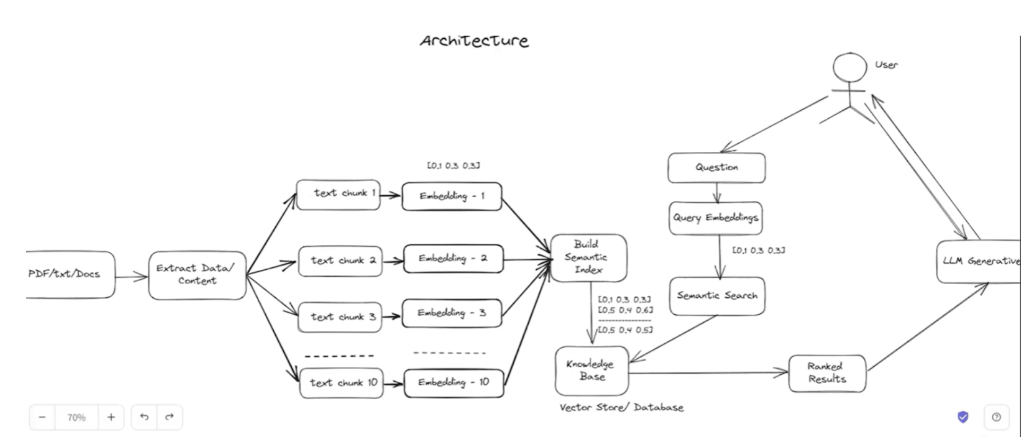


Applications of RAG:

* Question Answering
* Chatbots
* Content Creation

RAG is particularly useful in scenarios where the generative model alone might not have sufficient knowledge or context to provide accurate responses. By combining retrieval with generation, RAG aims to improve the quality and reliability of AI-generated content.


.

In [ ]:
! pip install langchain langchain-community openai weaviate-client tiktoken -q

In [ ]:
import requests
from langchain.document_loaders import TextLoader


In [ ]:
'''Fetching the new document from web source and
then storing the same into a txt file'''

url = "https://raw.githubusercontent.com/hwchase17/chat-your-data/master/state_of_the_union.txt"
req = requests.get(url)
with open('state_of_the_union.txt', 'w') as f:
    f.write(req.text)



In [ ]:
# Loading the data using Lanhchain

loader = TextLoader('state_of_the_union.txt')
document = loader.load()
content = document[0].page_content


Looking into the RAG architecture, next step is chunking.

In [ ]:
# Chunking
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter(chunk_size = 500, chunk_overlap = 100)
chunks = text_splitter.split_documents(documents=document)
chunks[0].page_content

'Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans.  \n\nLast year COVID-19 kept us apart. This year we are finally together again. \n\nTonight, we meet as Democrats Republicans and Independents. But most importantly as Americans. \n\nWith a duty to one another to the American people to the Constitution. \n\nAnd with an unwavering resolve that freedom will always triumph over tyranny.'

In [ ]:
# Creating Embeddings

from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Weaviate
from weaviate import Client
from weaviate.embedded import EmbeddedOptions


In [ ]:
from google.colab import userdata
OPENAI_API_KEY=userdata.get('OPENAI_API_KEY')

In [ ]:
client = Client(embedded_options=EmbeddedOptions())
vector_store = Weaviate.from_documents(client=client,
                        documents = chunks,
                        embedding = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY),
                        by_text = False)



INFO:weaviate-client:embedded weaviate is already listening on port 8079


In [ ]:
retriever = vector_store.as_retriever()

In [ ]:
from langchain.prompts import ChatPromptTemplate
template="""You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use ten sentences maximum and keep the answer concise.
Question: {question}
Context: {context}
Answer:
"""

In [ ]:
prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks.\nUse the following pieces of retrieved context to answer the question.\nIf you don't know the answer, just say that you don't know.\nUse ten sentences maximum and keep the answer concise.\nQuestion: {question}\nContext: {context}\nAnswer:\n"))])

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser


In [ ]:
llm_model = ChatOpenAI(openai_api_key = OPENAI_API_KEY, model_name = 'gpt-3.5-turbo')

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [ ]:
query = 'Who is Putin?'



In [ ]:
# Langchain expression language is used to build the chain.
output_parser = StrOutputParser()


chain = prompt | llm_model | output_parser

chain.invoke({"question": query, 'context': retriever})



"Vladimir Putin is the President of Russia. He has been in power since 1999. Putin was born in Leningrad in 1952. He served as Prime Minister of Russia from 1999 to 2000 and again from 2008 to 2012. Putin has been criticized for his authoritarian leadership style. He is known for his strong stance on foreign policy issues. Putin has been accused of human rights abuses and suppressing political opposition. He is a controversial figure both in Russia and on the international stage. Putin is often seen as a polarizing figure in global politics. His actions have had a significant impact on Russia's relationship with other countries."